In [30]:
# SEL 1: SETUP, LOAD DATA, DAN DEFINISI VARIABEL

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Pastikan Anda sudah menginstal pustaka yang dibutuhkan untuk membaca XLSX
# Jika Anda menggunakan Colab, jalankan: !pip install openpyxl

# Pengaturan visualisasi
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

# --- JALUR FILE DIKOREKSI UNTUK XLSX ---
# Gunakan nama file XLSX yang benar dan tentukan sheet-nya
file_rapor = "/content/data_an.xlsx"
sheet_name = "rapor_publik" # Ini adalah nama sheet yang berisi data utama

try:
    # KUNCI SOLUSI: Menggunakan pd.read_excel() dan menentukan sheet
    df = pd.read_excel(file_rapor, sheet_name=sheet_name)
    print("Data berhasil dimuat dari file XLSX.")
except Exception as e:
    # Ini adalah jalur file Colab, jadi harus menggunakan jalur /content/
    try:
        file_rapor_path = f"/content/{file_rapor}"
        df = pd.read_excel(file_rapor_path, sheet_name=sheet_name)
        print("Data berhasil dimuat dari file XLSX menggunakan jalur Colab.")
    except Exception as e_colab:
        print(f"ERROR FATAL: Gagal memuat file XLSX. Pastikan file '{file_rapor}' sudah diunggah dan sheet-name '{sheet_name}' benar.")
        print(f"Detail Error: {e_colab}")
        raise # Hentikan eksekusi jika gagal memuat data

print(f"\nJumlah baris dan kolom awal: {df.shape}")

# SS 1.1: Data Head
print("\n--- SS 1.1: Data Head ---")
print(df.head().to_markdown(index=False))

# SS 1.2: Data Info
print("\n--- SS 1.2: Data Info ---")
df.info()

# --- PENDEFINISIAN VARIABEL ---
TARGET_COLUMN = 'LIT' # Target y: Skor Numerik Literasi (Regresi)
SK_FEATURES = ['AAKN', 'AAMN', 'AAPR', 'ABKR', 'ABMK', 'AMKA', 'AMKB', 'AMKG', 'AMTA', 'AMTB']
SLB_FEATURES = ['ACH', 'AIN', 'AKC', 'BCP', 'BUL', 'CAF', 'DIB', 'DIC', 'DIE', 'ECP', 'ENP', 'EQC', 'EQR', 'ESA', 'ESV', 'ISB', 'ITB', 'KKG', 'OCC', 'PBR', 'PBU', 'PCP', 'PKG', 'PLIT', 'PMU', 'PNUM', 'POT', 'PSA', 'PSV', 'RKG', 'RPI', 'SAF', 'SBU', 'SKG', 'TAS', 'TOC', 'TOR', 'TSC', 'WEL']
SES_FEATURES = ['SES_siswa', 'SES_sekolah']
FEATURES = SK_FEATURES + SLB_FEATURES + SES_FEATURES
ALL_COLS_TO_USE = [TARGET_COLUMN] + FEATURES

Data berhasil dimuat dari file XLSX.

Jumlah baris dan kolom awal: (48060, 136)

--- SS 1.1: Data Head ---
|   kd_sekolah | pendidikan_sederajat   | jenis_sek   | sts_sek   | kurikulum         | daerah_khusus   |   kd_kokab | wilayah_bagian   | jenis_wilayah   | status_wilayah   |   proporsi_pendidik_min_s1 |   proporsi_pendidik_sertifikasi |   jumlah_peserta_didik |   jumlah_pendidik |   rasio_pendidik_peserta_didik |   jumlah_r_kelas | ketersediaan_internet   | ketersediaan_listrik   |   jumlah_komp_milik |   jumlah_perpus |   jumlah_rombel |   jumlah_siswa_rombel |   jumlah_siswa_penerima_PIP |   rasio_siswa_penerima_PIP | kd_siswa_an    | bg1   | bg2   | bg3   | bg4   | bg5   | bg6   | bg7   | bg8   | bg9   | bg10   | bg11   | bg12   | bg13   | bg14   | bg15   | bg16   | bg17   | bg18   | bg19   | bg20   | bg21   | bg22   | bg23   | bg24   | bg25   |   SES_siswa |    LIT |   LIT_INF |   LIT_SAS |   LIT_L1 |   LIT_L2 |   LIT_L3 |   NUM |   NUM_ALJ |   NUM_GEO |   NUM_BIL |   NUM_DAT

In [33]:
# SEL 2: DATA PREPARATION (Pembersihan, Imputasi, dan Pembagian Data)

# --- 2. DATA PREPARATION ---
df_clean = df[ALL_COLS_TO_USE].copy()

# SS 2.1: Missing Values Awal
print("\n--- SS 2.1: Missing Values Awal ---")
missing_values = df_clean.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0].to_markdown())

# Strategi 1: Hapus baris dengan TARGET yang hilang
rows_before = df_clean.shape[0]
df_clean.dropna(subset=[TARGET_COLUMN], inplace=True)
rows_after_target_drop = df_clean.shape[0]
print(f"\nBaris yang dihapus karena TARGET kosong: {rows_before - rows_after_target_drop}")


# --- SOLUSI KRITIS: Menghapus Kolom yang 100% Missing ---
# Identifikasi kolom yang semuanya kosong setelah baris LIT kosong dihapus
missing_after_target = df_clean[FEATURES].isnull().sum()
cols_to_drop = missing_after_target[missing_after_target == df_clean.shape[0]].index.tolist()

if cols_to_drop:
    df_clean.drop(columns=cols_to_drop, inplace=True)

    # Perbarui daftar FEATURES global agar konsisten
    global FEATURES
    FEATURES = [f for f in FEATURES if f not in cols_to_drop]
    print(f"\nKolom yang dihapus karena 100% kosong: {cols_to_drop}")

# Strategi 2: Imputasi fitur yang tersisa dengan Median
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
df_clean[FEATURES] = imputer.fit_transform(df_clean[FEATURES])

print("\nVerifikasi: Proses Imputasi Fitur Selesai.")
print(f"Jumlah baris setelah cleaning akhir: {df_clean.shape[0]}")

# --- 2.2 PEMBAGIAN DATA & SCALING ---
y = df_clean[TARGET_COLUMN]
X = df_clean[FEATURES]

# Pembagian Train dan Test Set (80:20) (SS Wajib)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\n--- SS 2.2: Pembagian Data ---")
print(f"Data Training: {X_train.shape[0]} baris | Data Testing: {X_test.shape[0]} baris")
#

# Scaling Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("\nData Training dan Testing sudah di-scaling dan siap untuk Modeling.")


--- SS 2.1: Missing Values Awal ---
|           |     0 |
|:----------|------:|
| BCP       | 48060 |
| ITB       | 48060 |
| SBU       | 48060 |
| DIC       | 33237 |
| DIB       | 32610 |
| EQR       | 32164 |
| DIE       | 30700 |
| RKG       | 29883 |
| PSA       | 29791 |
| RPI       | 29779 |
| PCP       | 29744 |
| PSV       | 29713 |
| PMU       | 29662 |
| PBU       | 29633 |
| POT       | 29604 |
| ESV       | 29603 |
| EQC       | 29583 |
| TOC       | 29579 |
| SKG       | 29529 |
| ESA       | 29517 |
| PKG       | 29515 |
| WEL       | 29506 |
| TOR       | 29494 |
| PNUM      | 29483 |
| BUL       | 29481 |
| AIN       | 29476 |
| ECP       | 29460 |
| TAS       | 29458 |
| TSC       | 29457 |
| KKG       | 29447 |
| OCC       | 29436 |
| ISB       | 29431 |
| SAF       | 29379 |
| CAF       | 29378 |
| AKC       | 29376 |
| PBR       | 29370 |
| PLIT      | 29357 |
| ACH       | 29355 |
| ENP       | 10820 |
| AMKB      |  4438 |
| AMKA      |  4414 |
| AMKG      |  43

In [34]:
# SEL 3: MODELING & EVALUATION (REGRESI)

# --- 3.1 MODELING: RANDOM FOREST REGRESSOR (SS Wajib) ---
print("\n--- 3.1 Pelatihan Model Random Forest Regressor ---")
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_regressor.fit(X_train_scaled, y_train)
print("Pelatihan model selesai.")

# --- 3.2 PREDIKSI DAN EVALUASI ---
y_pred = rf_regressor.predict(X_test_scaled)

# Hitung Metrik Regresi (SS Wajib)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\n--- SS 3.2: Metrik Evaluasi Regresi ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R² Score): {r2:.4f}")


--- 3.1 Pelatihan Model Random Forest Regressor ---
Pelatihan model selesai.

--- SS 3.2: Metrik Evaluasi Regresi ---
Mean Squared Error (MSE): 197.19
Root Mean Squared Error (RMSE): 14.04
R-squared (R² Score): 0.4963


## 🔍 Basic Info

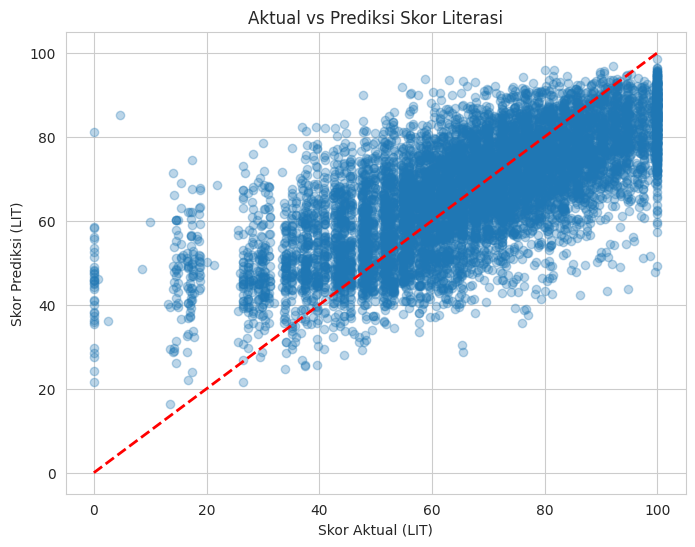


--- SS 3.3: Analisis Feature Importance ---


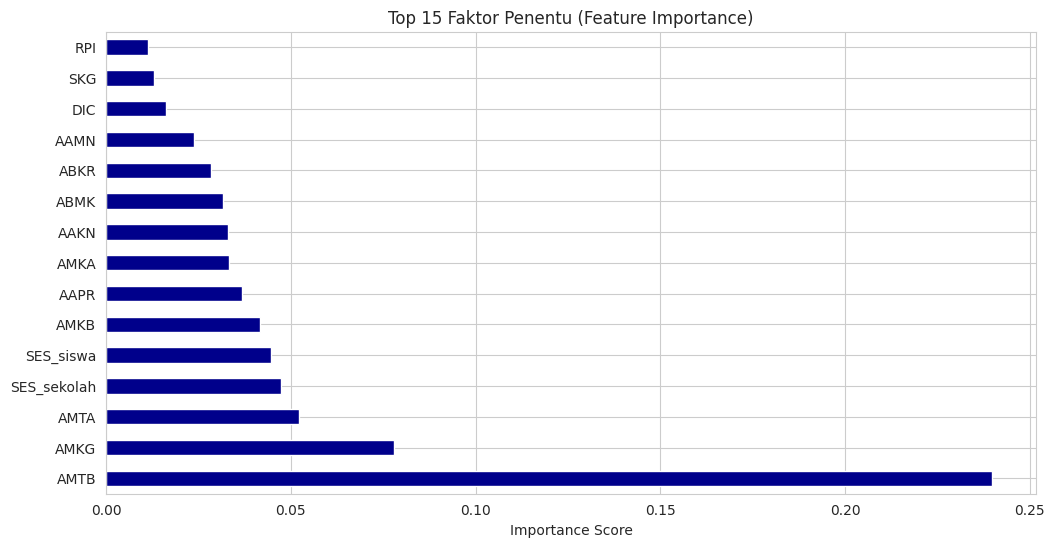

In [35]:
# SEL 4: VISUALISASI HASIL DAN FEATURE IMPORTANCE

# Visualisasi Prediksi vs Aktual (SS Wajib)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('Aktual vs Prediksi Skor Literasi')
plt.xlabel('Skor Aktual (LIT)')
plt.ylabel('Skor Prediksi (LIT)')
plt.savefig('actual_vs_predicted_scatter.png')
plt.show()

# --- 3.3 ANALISIS FEATURE IMPORTANCE ---
print("\n--- SS 3.3: Analisis Feature Importance ---")
importance = pd.Series(rf_regressor.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
importance[:15].plot(kind='barh', color='darkblue')
plt.title('Top 15 Faktor Penentu (Feature Importance)')
plt.xlabel('Importance Score')
plt.savefig('feature_importance_reg.png')
plt.show()

In [36]:
# SEL 5: DEPLOYMENT PREPARATION

# Simpan Model, Scaler, dan Feature Names
joblib.dump(scaler, 'scaler_reg_an.pkl')
joblib.dump(rf_regressor, 'random_forest_regressor_an.pkl')
joblib.dump(X.columns.tolist(), 'feature_names_reg.pkl')

print("\n--- SS 4.1: Model Persiapan Deployment Selesai ---")
print("Model, Scaler, dan Feature Names telah disimpan ke file .pkl dan siap untuk Gradio.")


--- SS 4.1: Model Persiapan Deployment Selesai ---
Model, Scaler, dan Feature Names telah disimpan ke file .pkl dan siap untuk Gradio.
